In [58]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver

In [59]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

In [60]:
from sympy import cos,sin,pi,symbols,diff,lambdify

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=u_symbolic**3-laplacian(u_symbolic)
f_symbolic

cos(4*pi*x)**3*cos(pi*y/2)**3 + 65*pi**2*cos(4*pi*x)*cos(pi*y/2)/4

In [61]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2

In [62]:
sigma=0.1
int_point_number=1500
ext_point_number=200

u=PDESolver(
    X_int=make_points_inside(int_point_number),
    X_boundary=make_points_boundary(ext_point_number),
    sigma=sigma)
u_1=PDESolver(
    X_int=make_points_inside(int_point_number),
    X_boundary=make_points_boundary(ext_point_number),
    sigma=sigma,
    name='1')
u_2=PDESolver(
    X_int=make_points_inside(int_point_number),
    X_boundary=make_points_boundary(ext_point_number),
    sigma=sigma,
    name='2')
u_1.fit(f,real_u,tau,dtau,nugget=1e-5)
u_2.fit(f,real_u,tau,dtau,nugget=1e-5)
u.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 1.504e-08: : 4it [00:04,  1.09s/it]
Current residual 4.516e-09: : 4it [00:04,  1.02s/it]
Current residual 7.348e-09: : 4it [00:03,  1.01it/s]


In [63]:
def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

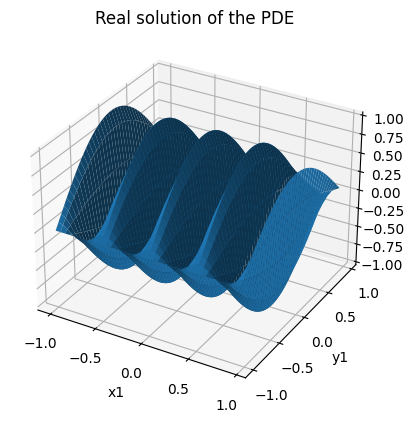

In [64]:
fig=plot_function(real_u)
plt.title('Real solution of the PDE')
plt.show()

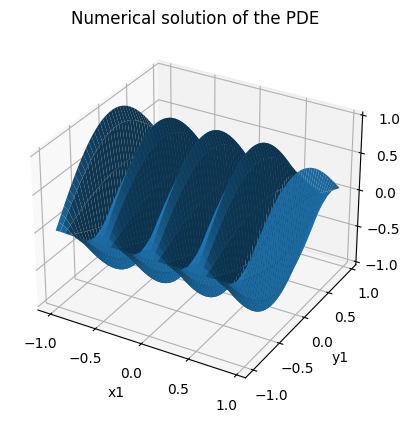

In [65]:
fig=plot_vectorized_function(u)
plt.title('Numerical solution of the PDE')
plt.show()

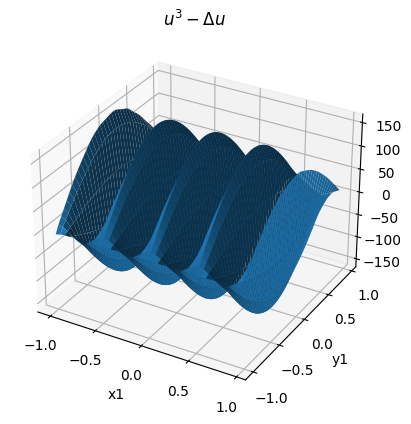

In [66]:
fig=plot_vectorized_function(lambda x:u(x)**3-u.laplacian(x))
#fig=plot_vectorized_function(lambda x:u.laplacian(x))
plt.title('$u^3-\Delta u$')
plt.show()

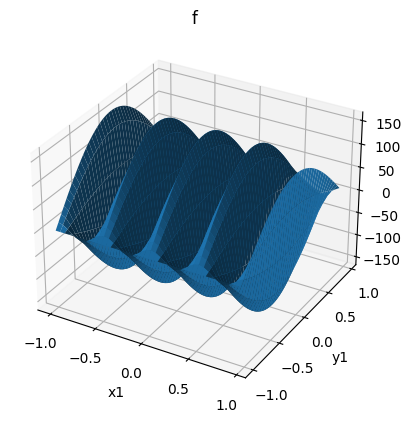

In [67]:
fig=plot_function(f)
plt.title('f')
plt.show()

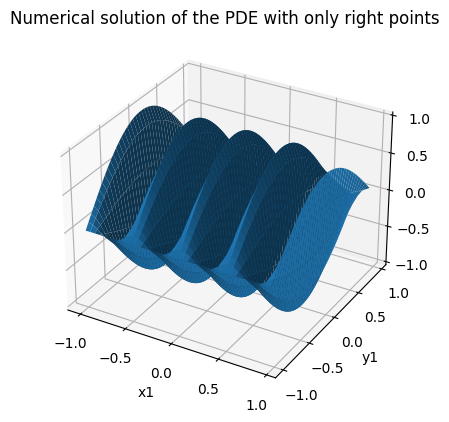

In [68]:
fig=plot_vectorized_function(u_1)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

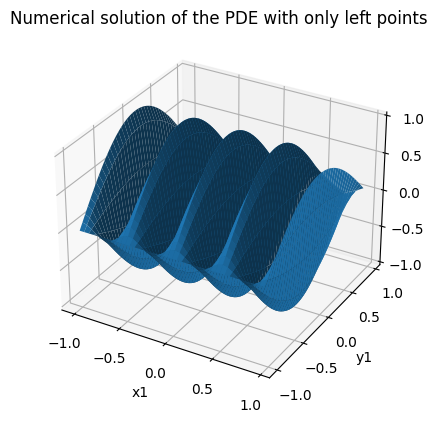

In [69]:
fig=plot_vectorized_function(u_2)
plt.title('Numerical solution of the PDE with only left points')
plt.show()

In [70]:
aggregate=Aggregate([u_1,u_2],sigma=sigma,nugget=1e-5)

M [[-2.61979071e-04 -5.51676733e-05]
 [ 1.10319178e-03 -1.54818469e-05]
 [ 3.64317263e-04 -2.40079320e-05]
 ...
 [-2.36691988e-02 -2.48124313e-02]
 [ 2.46491824e-02  2.32917587e-02]
 [ 6.35631755e-02  6.16657641e-02]]
COV mat [[[1.00000169 0.99998178]
  [0.99998178 0.99999975]]

 [[1.00000186 0.99998662]
  [0.99998662 1.00000456]]

 [[0.99999769 0.99998433]
  [0.99998433 1.00000632]]

 ...

 [[1.00000692 0.99999214]
  [0.99999214 1.00000484]]

 [[1.00000782 0.99998749]
  [0.99998749 1.00000046]]

 [[1.00000795 0.99999314]
  [0.99999314 1.00000472]]]
COV Y [[0.99999169 0.99998975]
 [0.99999186 0.99999456]
 [0.99998769 0.99999632]
 ...
 [0.99999692 0.99999484]
 [0.99999782 0.99999046]
 [0.99999795 0.99999472]]
alpha [[0.52553221 0.47446724]
 [0.45931996 0.54067828]
 [0.37791642 0.62208189]
 ...
 [0.53778809 0.46220874]
 [0.61055798 0.38943994]
 [0.56127901 0.43871749]]


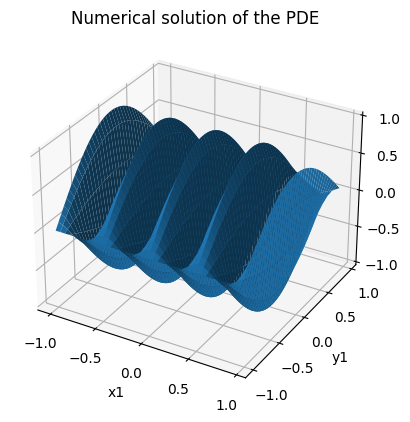

In [71]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [72]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U = u(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_1=u_1(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_2=u_2(np.stack([X.flatten(),Y.flatten()],axis=-1))

cov_1=u_1.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_2=u_2.covariate_with_sol(np.stack([X.flatten(),Y.flatten()],axis=-1))
cov_inter=u_2.covariate_with_other(u_1,np.stack([X.flatten(),Y.flatten()],axis=-1),sigma=0.1)
alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))

M [[-2.61979071e-04 -5.51676733e-05]
 [ 2.48853625e-04  1.38818520e-05]
 [ 6.38497751e-04  3.89109696e-05]
 ...
 [ 1.43753919e-02  1.33166982e-02]
 [ 1.49571979e-02  1.36179274e-02]
 [ 1.53921486e-02  1.35692271e-02]]
COV mat [[[1.00000169 0.99998178]
  [0.99998178 0.99999975]]

 [[1.00000384 0.99998978]
  [0.99998978 1.00000581]]

 [[1.00000392 0.99999037]
  [0.99999037 1.0000061 ]]

 ...

 [[1.00000073 0.99996976]
  [0.99996976 0.99998772]]

 [[0.99999886 0.99993211]
  [0.99993211 0.99995249]]

 [[1.00000141 0.99984515]
  [0.99984515 0.99986391]]]
COV Y [[0.99999169 0.99998975]
 [0.99999384 0.99999581]
 [0.99999392 0.9999961 ]
 ...
 [0.99999073 0.99997772]
 [0.99998886 0.99994249]
 [0.99999141 0.99985391]]
alpha [[0.52553221 0.47446724]
 [0.46731736 0.53268014]
 [0.4627892  0.53720809]
 ...
 [0.63289816 0.36710321]
 [0.76614933 0.23385627]
 [0.89284111 0.10716563]]
COV mat [[[1.00000169 0.99998178]
  [0.99998178 0.99999975]]

 [[1.00000384 0.99998978]
  [0.99998978 1.00000581]]

 [[1

In [73]:
np.linalg.norm(U-U_real,ord=np.inf)

0.003136277240851291

In [74]:
np.linalg.norm(U_real-U_agg,ord=np.inf)

0.0026349201947812873

In [75]:
np.linalg.norm(U_real-U_1,ord=np.inf)

0.00414267666549184

In [76]:
np.linalg.norm(U_real-U_2,ord=np.inf)

0.005993679996266876

In [77]:
x_sample=np.array([[-0.7,-0.6]])
print(real_u(x_sample[0]))
aggregate(x_sample)

-0.47552825814757677
M [[-0.47587826 -0.47490602]]
COV mat [[[1.00000948 0.99999746]
  [0.99999746 1.00000586]]]
COV Y [[0.99999948 0.99999586]]
alpha [[0.58872795 0.41126699]]


array([-0.475476])

In [78]:
aggregate.alpha(x_sample)

COV mat [[[1.00000948 0.99999746]
  [0.99999746 1.00000586]]]
COV Y [[0.99999948 0.99999586]]


array([[0.58872795, 0.41126699]])

# Is $\sum_i \alpha_i=1$ ? 

In [79]:
np.max(np.abs(np.sum(alpha,axis=-1)-1))

9.572952350156427e-06

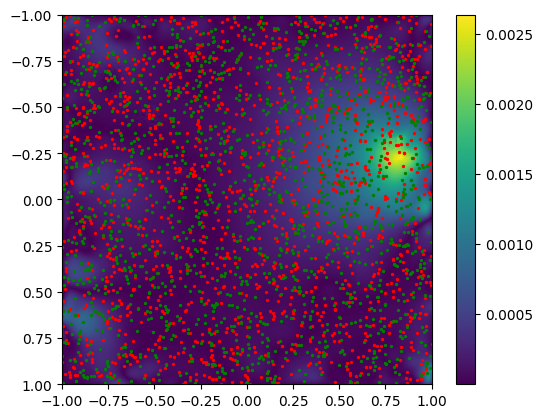

In [80]:
ax=plt.subplot()
im = ax.imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='r',s=2)
ax.scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='g',s=2)
plt.colorbar(im)

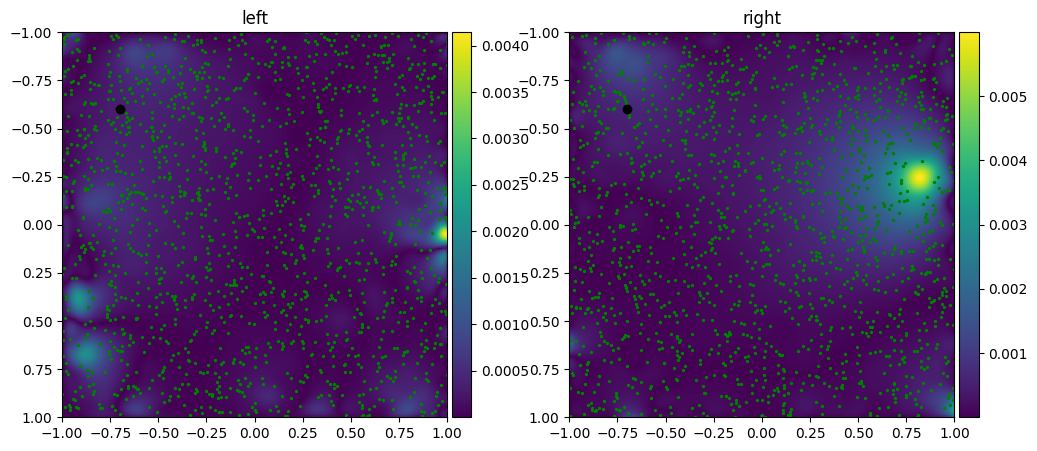

In [81]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.abs(U_1-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U_2-U_real).reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

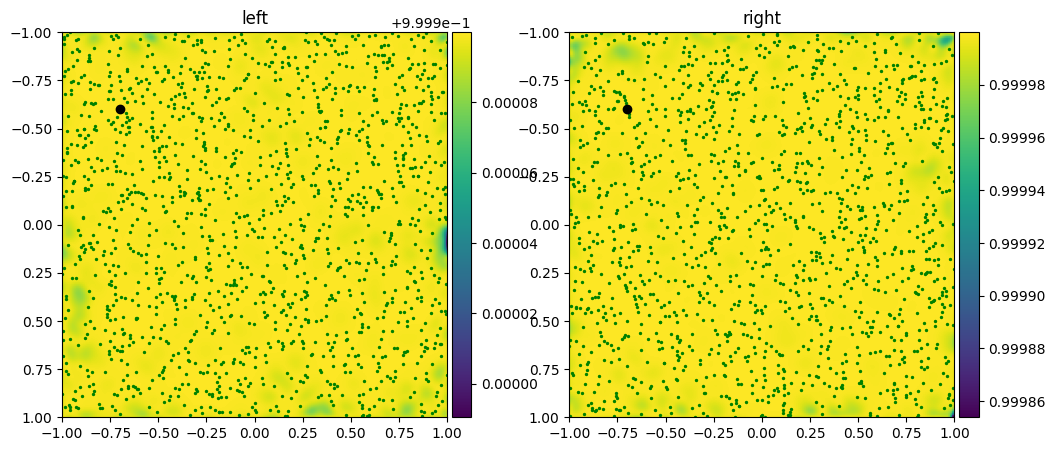

In [82]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(cov_1.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(cov_2.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='g',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

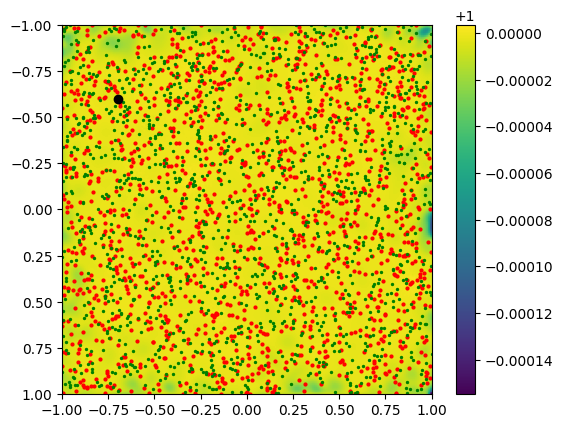

In [83]:
ax=plt.subplot()
im = ax.imshow(cov_inter.reshape(X.shape),extent=[-1,1,1,-1])
ax.scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='r',s=4)
ax.scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
ax.scatter(x_sample[:,0],x_sample[:,1],c='k')
plt.colorbar(im)

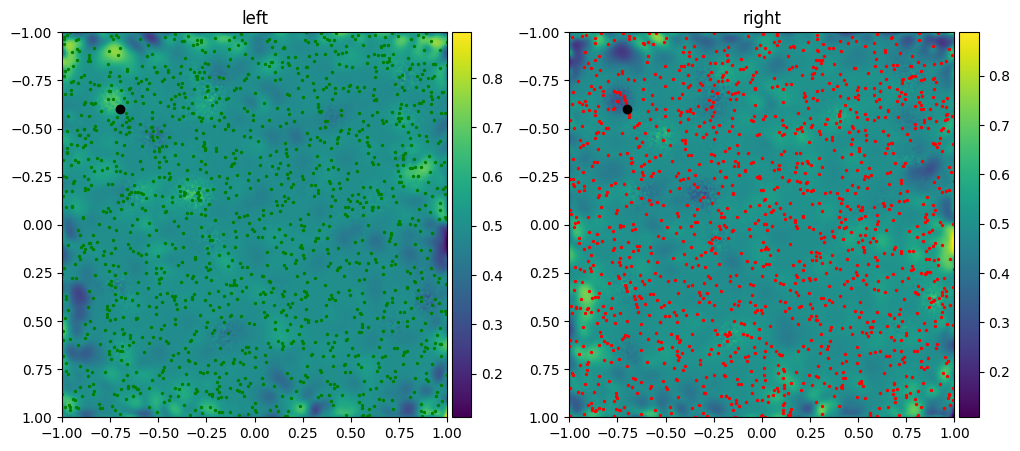

In [84]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha[:,0].reshape(X.shape),extent=[-1,1,1,-1])
axes[0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=2)
axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('left')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(alpha[:,1].reshape(X.shape),extent=[-1,1,1,-1])
axes[1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='r',s=2)
axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('right')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# Stop below

In [85]:
print(1/0)

ZeroDivisionError: division by zero

In [ ]:
def make_an_aggregate(N_int,N_boundary):
    X_int_left=make_points_inside(N_int)
    X_int_right=make_points_inside(N_int)
    X_boundary_left=make_points_boundary(N_boundary)
    X_boundary_right=make_points_boundary(N_boundary)
    sigma=3*(pairwise_distances(X_int_left)+1000*np.eye(X_int_left.shape[0])).min(axis=1).mean()
    u_1=PDESolver(X_int=X_int_left[X_int_left[:,0]<0.2],X_boundary=X_boundary_left[X_boundary_left[:,0]<0.2],sigma=sigma,name='left')
    u_1.fit(f,real_u,tau,dtau,nugget=1e-5)
    u_2=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right[X_boundary_right[:,0]>-0.2],sigma=sigma,name='right')
    u_2.fit(f,real_u,tau,dtau,nugget=1e-5)

    aggregate=Aggregate([u_1,u_2],sigma=sigma,nugget=1e-4)
    return u_1,u_2,aggregate

def get_error(aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    return np.linalg.norm(U_real-U_agg),np.linalg.norm(U_real-U_agg,ord=np.inf)

def make_plot(u_1,u_2,aggregate):
    x = y = np.arange(-1.0, 1.0, 0.01)
    X, Y = np.meshgrid(x, y)
    U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
    u_1=u_1(np.stack([X.flatten(),Y.flatten()],axis=-1))
    u_2=u_2(np.stack([X.flatten(),Y.flatten()],axis=-1))
    alpha=aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))


    fig,axes=plt.subplots(3,2,figsize=(30,30))
    im = axes[0,0].imshow(np.abs(u_1-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=4)
    axes[0,0].title.set_text('error of left model')

    divider = make_axes_locatable(axes[0,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im2 = axes[0,1].imshow(np.abs(u_2-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[0,1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='g',s=4)
    axes[0,1].title.set_text('error of right model')

    divider = make_axes_locatable(axes[0,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')


    im3 = axes[1,0].imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,0].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='r',s=4)
    axes[1,0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=6)
    axes[1,0].title.set_text('error of aggregate')
    divider = make_axes_locatable(axes[1,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    im4 = axes[1,1].imshow(np.abs(U_real).reshape(X.shape),extent=[-1,1,1,-1])
    axes[1,1].title.set_text('absolute value of solution')
    divider = make_axes_locatable(axes[1,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im4, cax=cax, orientation='vertical')

    im5 = axes[2,0].imshow(alpha[:,0].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,0].scatter(u_1.X_int[:,0],u_1.X_int[:,1],c='g',s=4)
    axes[2,0].title.set_text('alpha left')

    divider = make_axes_locatable(axes[2,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im5, cax=cax, orientation='vertical')

    im6 = axes[2,1].imshow(alpha[:,1].reshape(X.shape),extent=[-1,1,1,-1])
    axes[2,1].scatter(u_2.X_int[:,0],u_2.X_int[:,1],c='r',s=4)
    axes[2,1].title.set_text('alpha right')

    divider = make_axes_locatable(axes[2,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im6, cax=cax, orientation='vertical')

    plt.show()

    


In [ ]:
u_1,u_2,aggregate=make_an_aggregate(N_int=10000,N_boundary=1000)

0it [00:00, ?it/s]

KeyboardInterrupt: 

In [ ]:
make_plot(u_1,u_2,aggregate)

M [[ 5.15761422e-004 -6.19552716e-157]
 [ 1.14283268e-004 -4.32371226e-153]
 [ 9.51213397e-006 -2.69854607e-149]
 ...
 [ 9.36268389e-146  1.51252445e-002]
 [ 1.64241378e-149  1.56403057e-002]
 [ 2.57665629e-153  1.59235209e-002]]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/theobourdais/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3378, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_79419/3635802386.py", line 1, in <module>
    make_plot(u_left,u_right,aggregate)
  File "/var/folders/wz/lf_5120j21q0kjn46pqx15zr0000gn/T/ipykernel_79419/3864932853.py", line 26, in make_plot
    U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 174, in __call__
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 166, in alpha
  File "/Users/theobourdais/Desktop/Caltech/Research/model_aggregation/PDE_solver_backend.py", line 154, in inner_models_cov_matrix
    covs=np.array(list(map(lambda model_pair:Aggregate.covariate_models(model_pair[0],model

# Local convergence

In [ ]:
X_local=make_points_inside(Nd=2000,range=np.array[[-0.2,0.1],[-0.2,0.1]])
X_boundary_local=make_points_boundary(200)
u_local=PDESolver(X_int=X_local,X_boundary=X_boundary_local,sigma=0.1,name='local')
u_local.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 3.468e-07: : 8it [00:24,  3.05s/it]


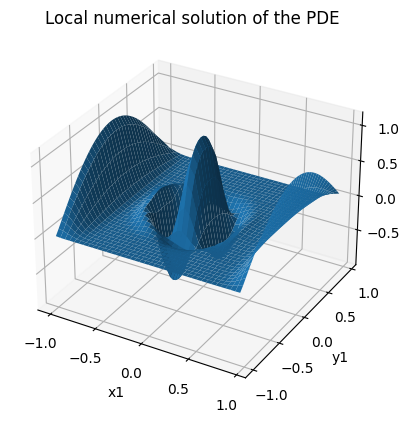

In [ ]:
fig=plot_vectorized_function(u_local)
plt.title('Local numerical solution of the PDE ')
plt.show()

In [ ]:
x = y = np.arange(-0.2, 0.1, 0.1)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U = u(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_loc= u_local(np.stack([X.flatten(),Y.flatten()],axis=-1))

In [ ]:
np.linalg.norm(U_real-U_loc,ord=np.inf)

0.45111099011852623

# Aggregating many models

In [87]:
def aggregate_many_models(N_models,N_points_inside,sigma,nugget_aggregate,nugget_model=1e-5):
    models=[]
    for k in range(N_models):
        models.append(PDESolver(X_int=make_points_inside(Nd=N_points_inside),
                  X_boundary=make_points_boundary(N_points_inside//10),
                  sigma=sigma,
                  name=f'model_{k}'))
        models[-1].fit(f,real_u,tau,dtau,nugget=nugget_model)
    return Aggregate(models,sigma=sigma,nugget=nugget_aggregate)


In [133]:
big_aggregate=aggregate_many_models(N_models=10,N_points_inside=400,sigma=0.2,nugget_aggregate=1e-5,nugget_model=1e-5)
constant_mean=lambda x:np.array(list(map(lambda model:model(x),big_aggregate.models))).T.mean(axis=-1)

Current residual 1.273e-08: : 5it [00:00, 21.91it/s]
Current residual 3.057e-07: : 6it [00:00, 26.11it/s]
Current residual 9.865e-07: : 6it [00:00, 24.57it/s]
Current residual 5.191e-08: : 5it [00:00, 26.45it/s]
Current residual 7.484e-09: : 5it [00:00, 27.63it/s]
Current residual 5.397e-08: : 5it [00:00, 26.57it/s]
Current residual 1.861e-07: : 8it [00:00, 28.35it/s]
Current residual 3.116e-08: : 5it [00:00, 28.28it/s]
Current residual 3.501e-07: : 5it [00:00, 21.16it/s]
Current residual 3.818e-07: : 6it [00:00, 29.55it/s]


M [[ 0.00600007 -0.02931183  0.0549087  ... -0.00304396 -0.01357197
   0.04542094]
 [ 0.01318635 -0.00998431  0.07963453 ...  0.00191855  0.00072015
   0.05563988]
 [ 0.01043328 -0.00110605  0.07846936 ... -0.0056702   0.00191824
   0.04376522]
 ...
 [-0.02934154 -0.02892219 -0.02379354 ...  0.04698507 -0.02515401
   0.03212807]
 [ 0.02474884  0.02331664  0.02588464 ...  0.10109082  0.02431766
   0.09101641]
 [ 0.06538264  0.06425754  0.06379577 ...  0.12941421  0.0634589
   0.13022252]]
COV mat [[[0.99996934 0.99975694 0.99938598 ... 0.99992218 0.99994038 0.99848862]
  [0.99975694 0.99979168 0.99919925 ... 0.9997627  0.99976895 0.99833555]
  [0.99938598 0.99919925 0.99941492 ... 0.99933107 0.99939307 0.99822555]
  ...
  [0.99992218 0.9997627  0.99933107 ... 0.99996929 0.99993943 0.9984469 ]
  [0.99994038 0.99976895 0.99939307 ... 0.99993943 0.99998688 0.99848889]
  [0.99848862 0.99833555 0.99822555 ... 0.9984469  0.99848889 0.99849743]]

 [[0.99997695 0.99992005 0.99911567 ... 0.99992

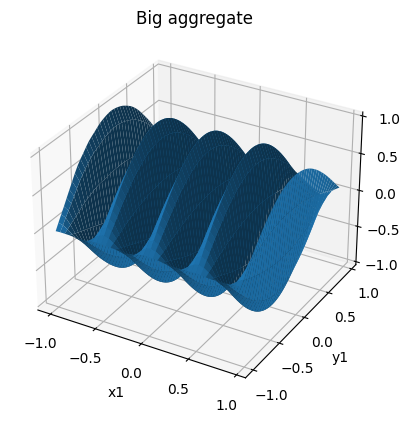

In [134]:
fig=plot_vectorized_function(big_aggregate)
plt.title('Big aggregate')
plt.show()

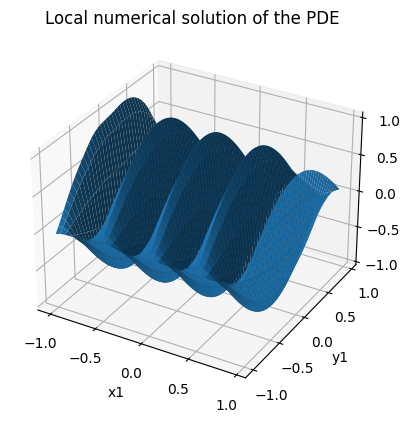

In [135]:
fig=plot_vectorized_function(big_aggregate.models[1])
plt.title('Local numerical solution of the PDE ')
plt.show()

In [136]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U_agg= big_aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_mean=constant_mean(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha=big_aggregate.alpha(np.stack([X.flatten(),Y.flatten()],axis=-1))
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)

M [[ 0.00600007 -0.02931183  0.0549087  ... -0.00304396 -0.01357197
   0.04542094]
 [ 0.0083196  -0.02456184  0.06193247 ... -0.00097334 -0.00957535
   0.04948039]
 [ 0.01019961 -0.02025043  0.06794753 ...  0.00056553 -0.00614491
   0.05252363]
 ...
 [ 0.02145775  0.01666215  0.0141677  ...  0.10618141  0.0147835
   0.10600001]
 [ 0.02034     0.0161246   0.01296245 ...  0.0998449   0.01444831
   0.10336684]
 [ 0.01844403  0.01495919  0.01122385 ...  0.09209547  0.01371201
   0.09960908]]
COV mat [[[0.99996934 0.99975694 0.99938598 ... 0.99992218 0.99994038 0.99848862]
  [0.99975694 0.99979168 0.99919925 ... 0.9997627  0.99976895 0.99833555]
  [0.99938598 0.99919925 0.99941492 ... 0.99933107 0.99939307 0.99822555]
  ...
  [0.99992218 0.9997627  0.99933107 ... 0.99996929 0.99993943 0.9984469 ]
  [0.99994038 0.99976895 0.99939307 ... 0.99993943 0.99998688 0.99848889]
  [0.99848862 0.99833555 0.99822555 ... 0.9984469  0.99848889 0.99849743]]

 [[0.99997885 0.99981151 0.99928462 ... 0.99995

In [144]:
alpha_norm=np.linalg.norm(alpha,axis=-1,ord=1)
error_big_agg=np.abs(U_real-U_agg)
error_mean=np.abs(U_real-U_mean)
error_each=[np.abs(U_real-model(np.stack([X.flatten(),Y.flatten()],axis=-1))) for model in big_aggregate.models]

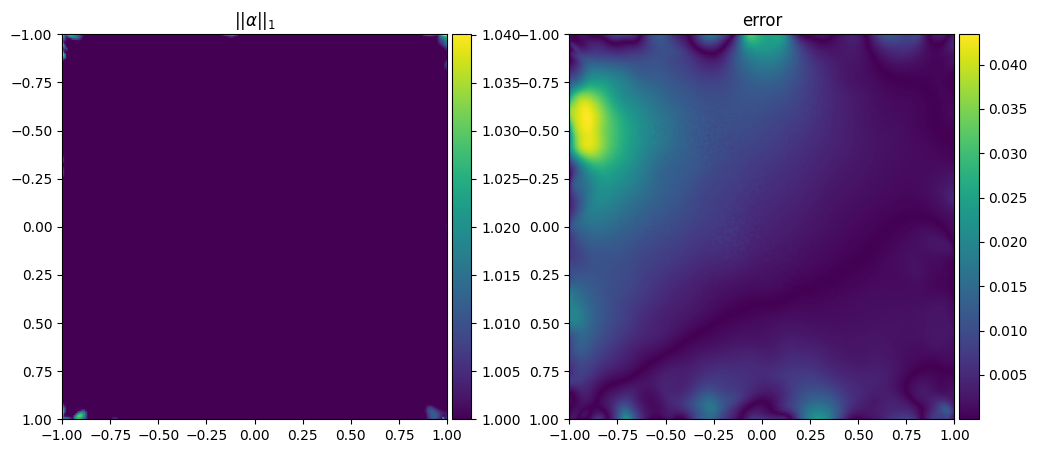

In [151]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha_norm.reshape(X.shape),extent=[-1,1,1,-1])
axes[0].title.set_text('$|| \\alpha ||_1$')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(error_big_agg.reshape(X.shape),extent=[-1,1,1,-1])
axes[1].title.set_text('error')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

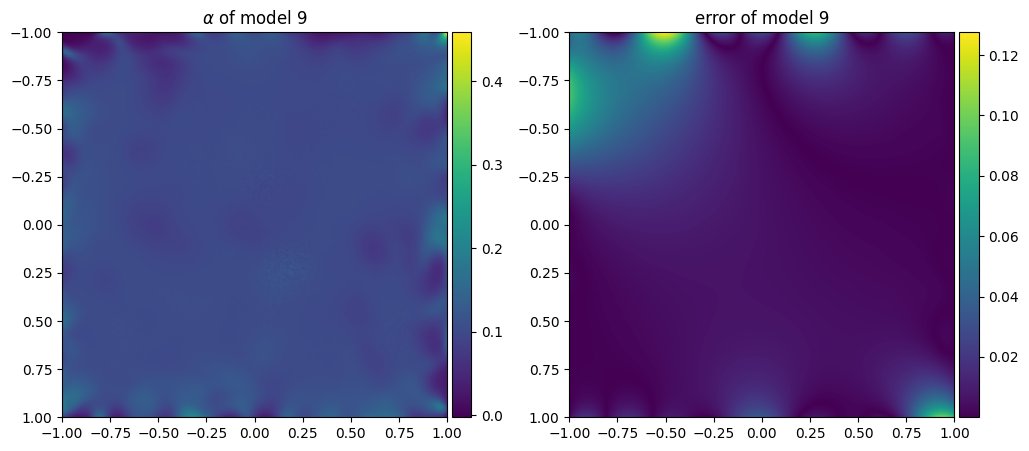

In [152]:
which=9

fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(alpha[:,which].reshape(X.shape),extent=[-1,1,1,-1])
axes[0].title.set_text(f'$\\alpha $ of model {which}')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(error_each[which].reshape(X.shape),extent=[-1,1,1,-1])
axes[1].title.set_text(f'error of model {which}')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

# Comparison of errors

In [154]:
print(f'mean aggregation : {error_mean.max():.2e}')
print(f'alpha aggregation : {error_big_agg.max():.2e}')

mean aggregation : 5.69e-02
alpha aggregation : 4.34e-02


In [140]:
np.max(np.abs(np.sum(alpha,axis=-1)-1))

2.35861067963139e-05

In [141]:
alpha[0]

array([ 0.08625502, -0.00319039,  0.00757675,  0.20650481,  0.14463018,
        0.33907926, -0.01146449,  0.08909673,  0.14412264, -0.00260793])